<a href="https://colab.research.google.com/github/sprince0031/CS4445-AI-Practice/blob/main/Week-8_Interpretability-and-Explainable-ML.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 8 Exercise: Interpretability and Explainable ML**

Welcome to **Week 8**!

This notebook explores techniques for interpreting and explaining machine learning models, focusing on object detection.

We'll use a pre-trained object detector and visualize layer activations to understand how the model identifies objects.

---

## 1. Imports and setup
Include all the required imports and setup

In [1]:
!pip install torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL.Image as Image

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load Pre-trained Model and Example Image

Now we load a pre-trained Faster R-CNN model from Torchvision. This model is designed for object detection tasks, and we set it to evaluation mode since we are not training it. We also define image transformations to convert input images into the format expected by the model. This cell lays the groundwork for passing an image through the model to later visualize hidden activations and compute interpretability measures.

In [3]:
# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)
model.eval()

# Define image transformations
transform = transforms.Compose([
    # transforms.Resize((800, 800)),  # Resize to a larger fixed shape for detection
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 164MB/s]


In [4]:
# Summary of the model to look at the layers
summary(model)

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [5]:
print("\nDetailed Layer Information:")
for name, layer in model.named_modules():  # Iterate through named modules
    print(f"Layer Name: {name}")
    # Add any layer-specific information you want to print here
    # Example: Print layer type
    print(f"Layer Type: {type(layer).__name__}")
    print("-" * 20)  # Separator


Detailed Layer Information:
Layer Name: 
Layer Type: FasterRCNN
--------------------
Layer Name: transform
Layer Type: GeneralizedRCNNTransform
--------------------
Layer Name: backbone
Layer Type: BackboneWithFPN
--------------------
Layer Name: backbone.body
Layer Type: IntermediateLayerGetter
--------------------
Layer Name: backbone.body.conv1
Layer Type: Conv2d
--------------------
Layer Name: backbone.body.bn1
Layer Type: FrozenBatchNorm2d
--------------------
Layer Name: backbone.body.relu
Layer Type: ReLU
--------------------
Layer Name: backbone.body.maxpool
Layer Type: MaxPool2d
--------------------
Layer Name: backbone.body.layer1
Layer Type: Sequential
--------------------
Layer Name: backbone.body.layer1.0
Layer Type: Bottleneck
--------------------
Layer Name: backbone.body.layer1.0.conv1
Layer Type: Conv2d
--------------------
Layer Name: backbone.body.layer1.0.bn1
Layer Type: FrozenBatchNorm2d
--------------------
Layer Name: backbone.body.layer1.0.conv2
Layer Type: Co

## 3. Visualize Layer Activations

Layer activation visualization is a powerful tool to understand what features a model extracts at various depths. In this section, we define a function that registers a forward hook on a specified layer of the model. As the image passes through the network, the hook collects the activation maps produced by that layer. These activation maps are then aggregated, normalized, and overlaid as a heatmap on the original image — providing visual insights into which parts of the image are emphasized by the network.

In [6]:
# COCO class names
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [7]:
def visualize_layer_activation(model, image, layer_name):
    """
    Visualize the activations of a specific layer in the model

    Args:
        model (torch.nn.Module): The neural network model
        image (torch.Tensor): Input image tensor [1, C, H, W]
        layer_name (str): Name of the layer to visualize

    Returns:
        dict: Detection results from the model
    """
    activation = None  # Initialize activation as None

    def hook(module, input, output):
        nonlocal activation  # Modify the outer scope activation variable
        activation = output

    # Find the target layer by name using a recursive helper function
    def find_layer_by_name(module, layer_name):
        for name, layer in module.named_modules():
            if name == layer_name:
                return layer
        return None

    target_layer = find_layer_by_name(model, layer_name)

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    hook_handle = target_layer.register_forward_hook(hook)

    result = model(image)  # Forward pass to activate the hook and retrieve activation

    hook_handle.remove()  # Remove the hook

    # Use a dummy activation map if activation is still None (layer not returning output)
    if activation is None:
        print(f"WARNING: Layer '{layer_name}' returned None. Visualizing dummy activation map.")
        activation = torch.zeros((1, 1, image.shape[2], image.shape[3]))

    # Process activation and generate heatmap
    activation = activation.mean(dim=1).squeeze()
    activation = (activation - activation.min()) / (activation.max() - activation.min())
    activation = activation.cpu().detach().numpy()

    image_np_original = (image.squeeze().permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)

    # Resize and overlay heatmap on the original image
    heatmap = cv2.resize(activation, (image.shape[3], image.shape[2]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    image_np = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()  # Convert image to NumPy
    overlayed_image = heatmap * 0.5 + (image_np * 255) * 0.5

    labels = result[0]['labels'].cpu().numpy()
    boxes = result[0]['boxes'].cpu().detach().numpy()
    scores = result[0]['scores'].cpu().detach().numpy()

    image_with_boxes = image_np_original.copy()

    if len(labels) > 0 and len(boxes) > 0:
        # Only process the first result
        image_with_boxes = image_np_original.copy()
        for i in range(min(len(boxes), 5)):
            box = boxes[i]
            label = labels[i]
            score = scores[i]

            x1, y1, x2, y2 = map(int, box)
            class_name = COCO_CLASSES[label]  # Map label to class name
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Green box
            cv2.putText(
                image_with_boxes,
                f'Pred {i+1}: {class_name}, Confidence: {score * 100:.2f}%',  # Overlay the class name
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),  # Blue text
                2
            )

    # Add progress feedback
    print(f"Processing layer: {layer_name}")
    print(f"Activation shape: {activation.shape}")

    # Create separate figures for activation and detection
    plt.figure(figsize=(15, 5))

    # plt.subplot(1, 3, 1)
    # plt.imshow(image_np_original)
    # plt.title("Original Image")
    # plt.axis('off')

    plt.subplot(1, 2, 1)
    plt.imshow(image_with_boxes.astype(np.uint8))
    plt.title("Detection Results")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image.astype(np.uint8))
    plt.title(f"Layer Activation: {layer_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return [COCO_CLASSES[label] for label in labels[:5]]

### How the above function works
1. This function begins by defining a hook that captures the output (`activation`) from a specified layer during the forward pass.
2. We search for the layer within the model using `named_modules()`, and if the layer is found, we register the forward hook.
3. The image is then passed through the model (in evaluation mode and without gradient tracking), which triggers the hook that saves the activation map.
4. After the forward pass, we remove the hook to avoid unintended side effects.
5. The function then computes a mean across channels, normalizes the activations, and resizes the activation map to match the original image dimensions.
6. The activation map is converted to a heatmap using OpenCV, then blended with the original image.
7. The prediction is also visualised by drawing the bounding boxes over the original image using opencv.
8. Finally, the result is displayed using Matplotlib. This provides insights into which regions of the image strongly activate the specified layer.

In [8]:
def loadImage(imagePath):
  # Load an example image
  image = Image.open(imagePath)  # Replace with your image path
  image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

  # Visualize the preprocessed image
  plt.figure(figsize=(8, 8))
  grid = make_grid(image.cpu(), nrow=1)  # Remove batch dimension for display
  plt.imshow(grid.permute(1, 2, 0))  # Convert CHW format to HWC for Matplotlib
  plt.axis('off')
  plt.show()
  return image

In [9]:
!mkdir -p datasets

In [10]:
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/dog.jpg -O datasets/dog.jpg
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/cat-and-dog.jpeg -O datasets/cat-and-dog.jpg
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/tiger.jpg -O datasets/tiger.jpg
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/dinning-table.jpg -O datasets/dining-table.jpg
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/tintin-meme.jpg -O datasets/tintin-meme.jpg

will be placed in the single file you specified.

--2025-03-05 11:30:11--  https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47018 (46K) [image/jpeg]
Saving to: ‘datasets/dog.jpg’

datasets/dog.jpg    100%[===================>]  45.92K  --.-KB/s    in 0.007s  

2025-03-05 11:30:12 (6.70 MB/s) - ‘datasets/dog.jpg’ saved [47018/47018]

FINISHED --2025-03-05 11:30:12--
Total wall clock time: 0.2s
Downloaded: 1 files, 46K in 0.007s (6.70 MB/s)
will be placed in the single file you specified.

--2025-03-05 11:30:12--  https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/staging/datasets/cat-and-dog.jpeg
Resolving raw.githubusercontent.com (raw

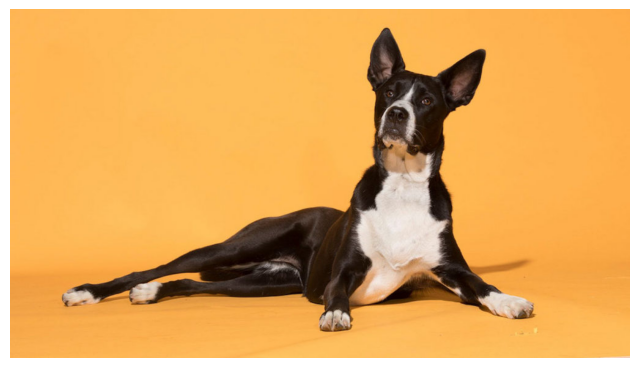

Processing layer: backbone.body.layer4
Activation shape: (24, 42)


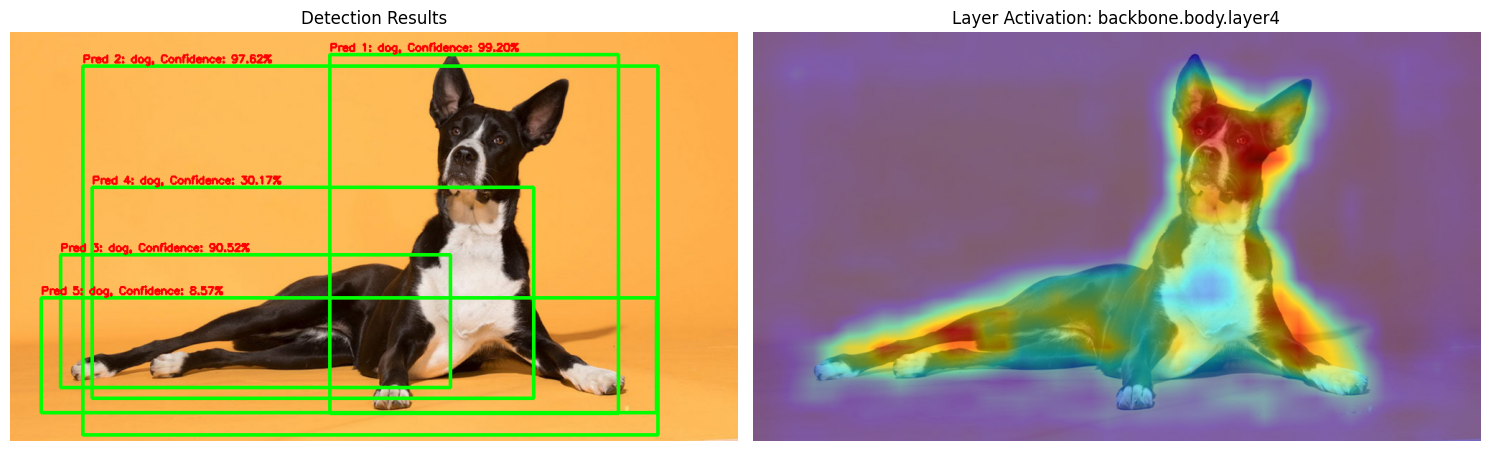

['dog', 'dog', 'dog', 'dog', 'dog']


In [11]:
# Load an example image
image = loadImage("datasets/dog.jpg")

preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)

## 4. Exercise: Interpret Activations

Analyze the generated visualizations to understand what parts of the image the model focuses on when detecting objects. Reflect on these points:
* Do the highlighted regions correspond to the objects themselves or to background features?
* How might these activations relate to the model’s confidence in its detections?
*  Try visualizing different layers to see how representations evolve through the network.

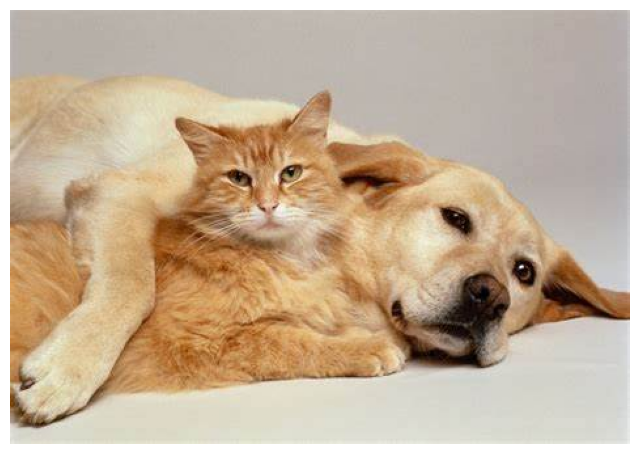

Processing layer: backbone.body.layer4
Activation shape: (25, 36)


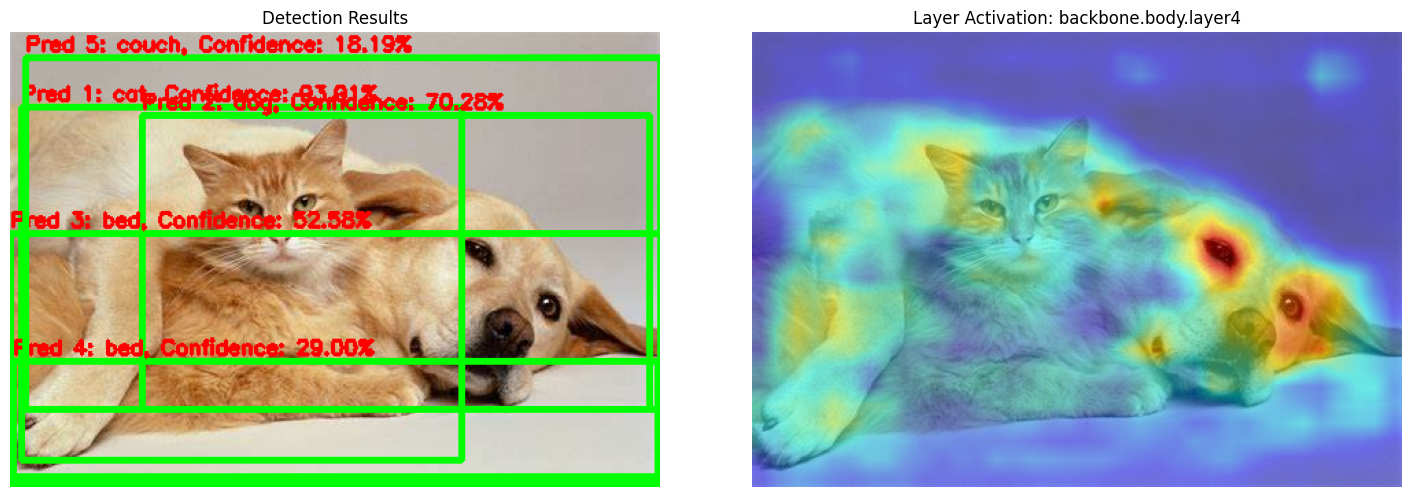

['cat', 'dog', 'bed', 'bed', 'couch']


In [12]:
# Load an example image
image = loadImage("datasets/cat-and-dog.jpg")

preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)

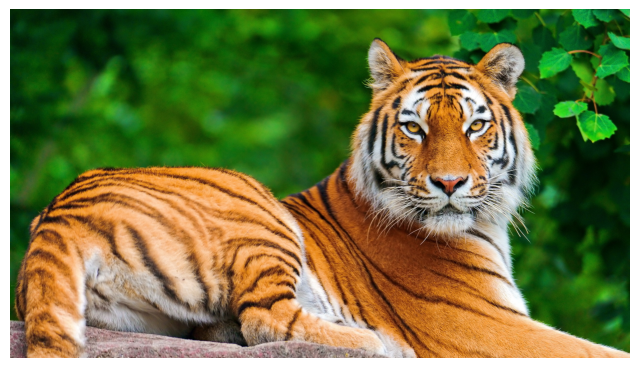

Processing layer: backbone.body.layer4
Activation shape: (24, 42)


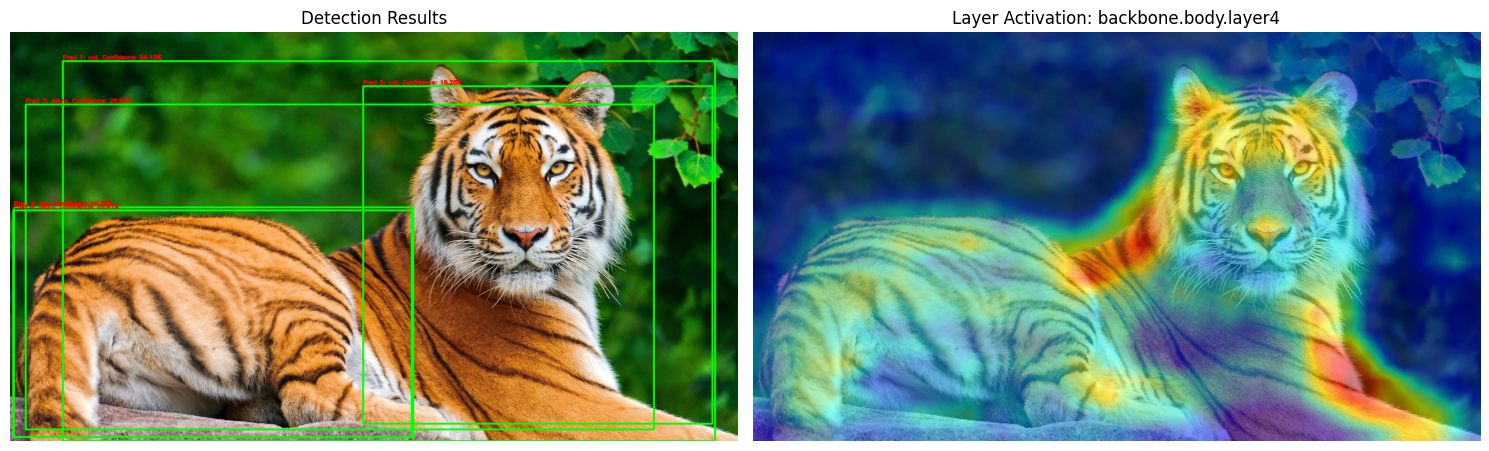

['cat', 'cat', 'zebra', 'zebra', 'cat']


In [20]:
image = loadImage("datasets/tiger.jpg")

preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)

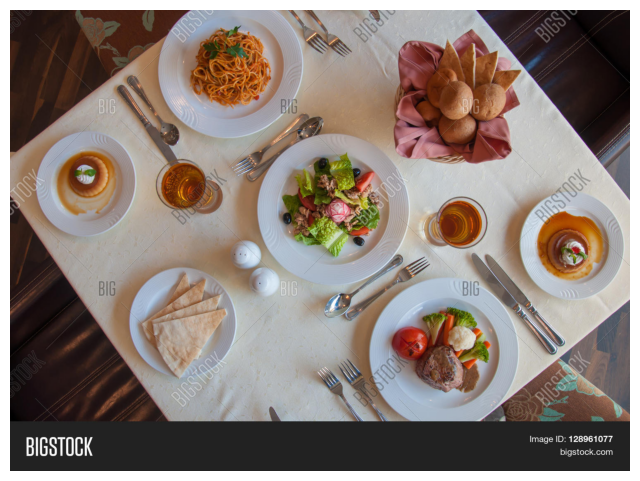

Processing layer: backbone.body.layer4
Activation shape: (25, 34)


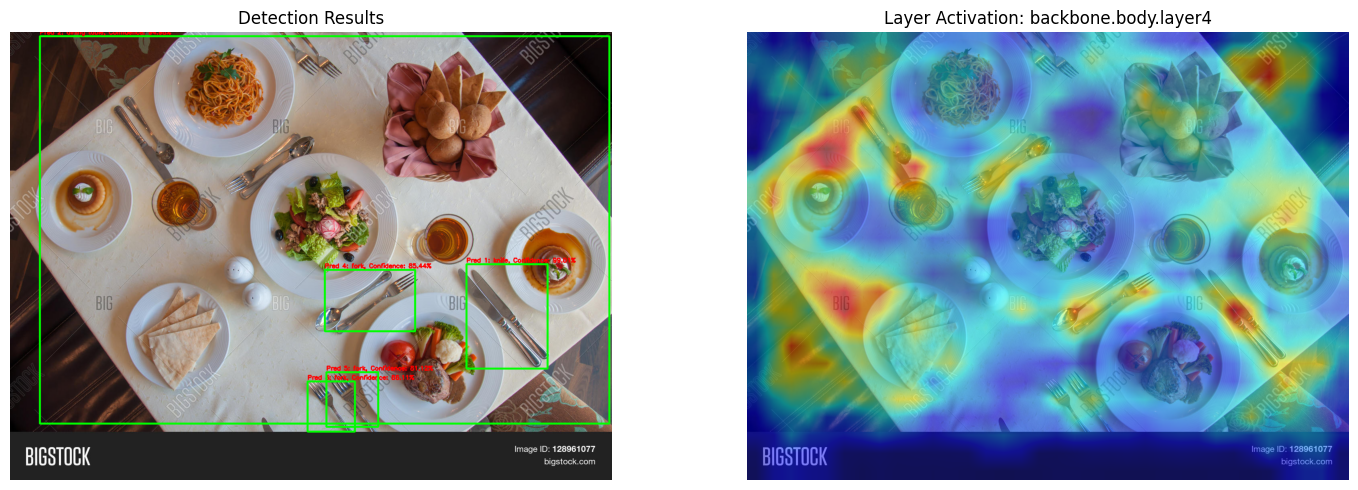

['knife', 'dining table', 'fork', 'fork', 'fork']


In [14]:
# Load an example image
image = loadImage("datasets/dining-table.jpg")  # Replace with your image path
preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)

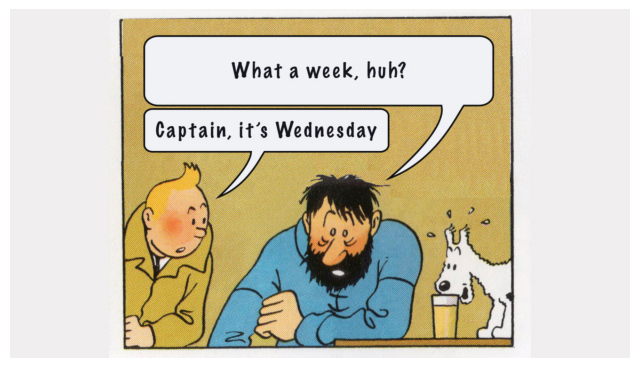

Processing layer: backbone.body.layer4
Activation shape: (24, 42)


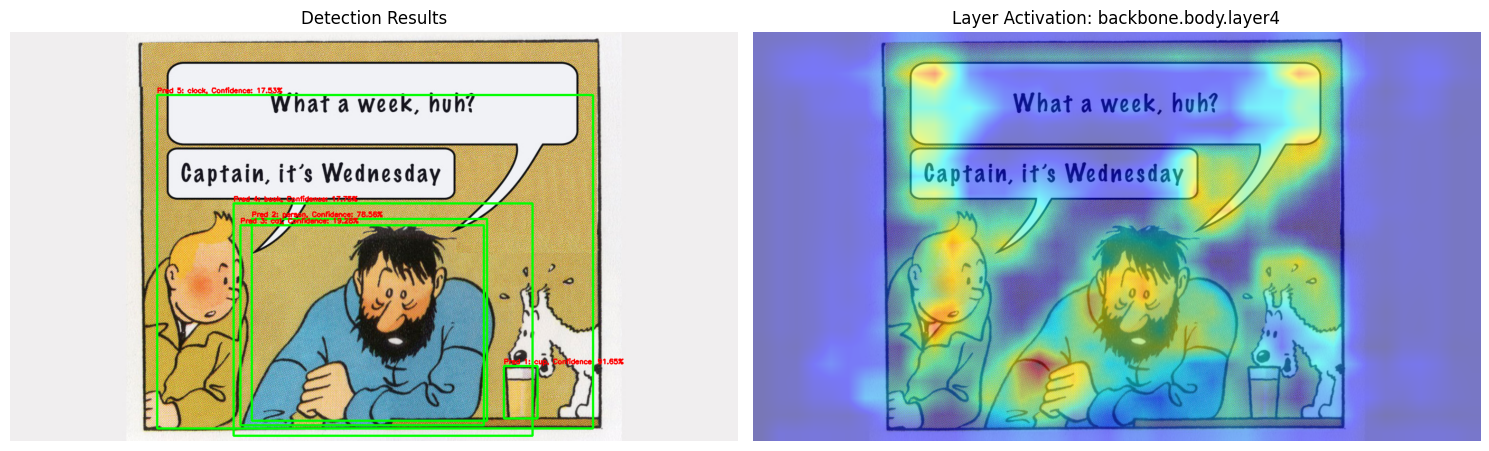

['cup', 'person', 'cat', 'book', 'clock']


In [15]:
# Load an example image
image = loadImage("datasets/tintin-meme.jpg")  # Replace with your image path
preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)

will be placed in the single file you specified.

--2025-03-05 11:48:26--  https://www.universityofcalifornia.edu/sites/default/files/berkeley_faces.jpg
Resolving www.universityofcalifornia.edu (www.universityofcalifornia.edu)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to www.universityofcalifornia.edu (www.universityofcalifornia.edu)|23.185.0.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26445 (26K) [image/jpeg]
Saving to: ‘datasets/faces.jpg’

datasets/faces.jpg  100%[===================>]  25.83K  --.-KB/s    in 0.002s  

2025-03-05 11:48:26 (12.2 MB/s) - ‘datasets/faces.jpg’ saved [26445/26445]

FINISHED --2025-03-05 11:48:26--
Total wall clock time: 0.1s
Downloaded: 1 files, 26K in 0.002s (12.2 MB/s)


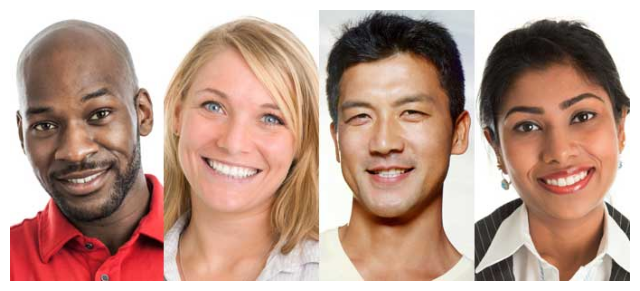

Processing layer: backbone.body.layer4
Activation shape: (19, 42)


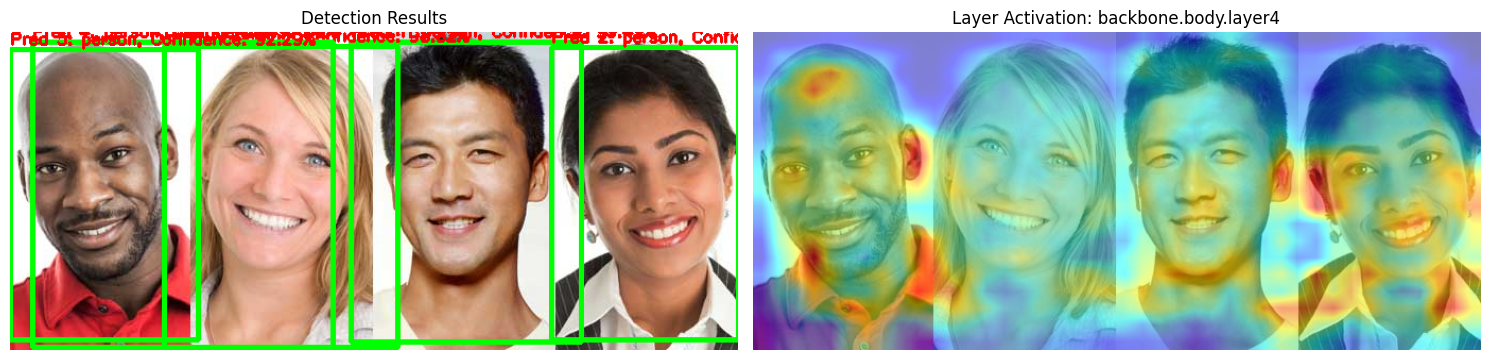

['person', 'person', 'person', 'person', 'person']


In [24]:
!wget -p https://www.universityofcalifornia.edu/sites/default/files/berkeley_faces.jpg -O datasets/faces.jpg
image = loadImage("datasets/faces.jpg")
preds = visualize_layer_activation(model, image, "backbone.body.layer4")
print(preds)
